In [2]:
!pip install jupysql clickhouse_sqlalchemy matplotlib python-dotenv pandas seaborn imageio > /dev/null 2>&1

In [2]:
import dotenv
import os
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import imageio

dotenv.load_dotenv()

# Load and display config
start_date = os.getenv('START_DATE_TIME')
if not start_date:
    raise ValueError("START_DATE_TIME environment variable is required")

end_date = os.getenv('END_DATE_TIME')
if not end_date:
    end_date = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")

network = os.getenv('NETWORK')

print(f"start_date: {start_date}")
print(f"end_date: {end_date}")

# Convert start and end dates to datetime objects
try:
    start_dt = datetime.fromisoformat(start_date.replace("Z", "+00:00"))
except ValueError as e:
    raise ValueError(f"Invalid start date format. Date must be in ISO format. Error: {str(e)}")

try:
    if isinstance(end_date, datetime):
        end_dt = end_date
    else:
        end_dt = datetime.fromisoformat(str(end_date).replace("Z", "+00:00"))
except ValueError as e:
    raise ValueError(f"Invalid end date format. Date must be in ISO format. Error: {str(e)}")

# Calculate the difference in hours
hours = (end_dt - start_dt).total_seconds() / 3600

print(f"hours: {hours}")


start_date: 2024-10-04T22:00:00Z
end_date: 2024-11-25T02:00:00Z
hours: 1228.0


In [3]:
# Connect to ClickHouse
import os
username = os.getenv('XATU_CLICKHOUSE_USERNAME')
password = os.getenv('XATU_CLICKHOUSE_PASSWORD')
host = os.getenv('XATU_CLICKHOUSE_HOST')


db_url = f"clickhouse+http://{username}:{password}@{host}:443/default?protocol=https"

from sqlalchemy import create_engine, text

engine = create_engine(db_url)

connection = engine.connect()

In [4]:
# Get head arrival times per client
print("Getting head arrival times...")
head_query = text("""
    SELECT 
        slot,
        propagation_slot_start_diff as head_arrival_time,
        meta_client_name
    FROM beacon_api_eth_v1_events_head FINAL
    WHERE 
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = 'mainnet'
    GROUP BY slot, meta_client_name, head_arrival_time
""")
head_times = pd.DataFrame(
    connection.execute(head_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')}).fetchall(),
    columns=['slot', 'head_arrival_time', 'meta_client_name']
)


Getting head arrival times...


In [5]:

# Get block arrival times per client
print("Getting block arrival times...")
block_query = text("""
    SELECT
        slot,
        propagation_slot_start_diff as block_arrival_time,
        meta_client_name
    FROM beacon_api_eth_v1_events_block FINAL 
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = 'mainnet'
    GROUP BY slot, meta_client_name, block_arrival_time
""")
block_times = pd.DataFrame(
    connection.execute(block_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')}).fetchall(),
    columns=['slot', 'block_arrival_time', 'meta_client_name']
)


Getting block arrival times...


In [7]:
# Get blob arrival times per client
print("Getting blob arrival times...")
blob_query = text("""
    SELECT
        slot,
        MAX(propagation_slot_start_diff) as last_blob_arrival_time,
        meta_client_name
    FROM beacon_api_eth_v1_events_blob_sidecar FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC') 
        AND meta_network_name = 'mainnet'
    GROUP BY slot, meta_client_name
""")
blob_times = pd.DataFrame(
    connection.execute(blob_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')}).fetchall(),
    columns=['slot', 'last_blob_arrival_time', 'meta_client_name']
)


Getting blob arrival times...


In [10]:

# Join all dataframes keeping client info
debug_arrival_times = head_times.merge(block_times, on=['slot', 'meta_client_name'], how='outer') \
                               .merge(blob_times, on=['slot', 'meta_client_name'], how='outer')

# Add first event time column per client
debug_arrival_times['first_event_time'] = debug_arrival_times[['head_arrival_time', 'block_arrival_time', 'last_blob_arrival_time']].min(axis=1)

In [11]:
checked_client_names = [
    'ethpandaops/mainnet/utility-mainnet-lighthouse-geth-001',
    'ethpandaops/mainnet/utility-mainnet-nimbus-besu-001',
    'ethpandaops/mainnet/utility-mainnet-lodestar-nethermind-001',
    'ethpandaops/mainnet/utility-mainnet-teku-erigon-001',
    'ethpandaops/mainnet/utility-mainnet-prysm-reth-001'
]

interesting_arrival_times = debug_arrival_times[debug_arrival_times['meta_client_name'].isin(checked_client_names)]


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_52439/3617652101.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interesting_arrival_times['first_event_type'] = interesting_arrival_times.apply(lambda row:
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_52439/3617652101.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interesting_arrival_times['last_event_time'] = interesting_arrival_times[['head_arrival_time', 'block_arrival_time', 'last_blob_arrival_time']].max(axis=1)
/var/fol


Average Distribution for utility-mainnet-nimbus-besu-001 (First Events):
Blob Event: 67.1%
Block Event: 10.6%
Head Event: 22.2%

Average Distribution for utility-mainnet-nimbus-besu-001 (Last Events):
Blob Event: 0.0%
Block Event: 0.2%
Head Event: 99.8%


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_52439/3617652101.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client_data['slot_bucket'], bins = pd.qcut(client_data['slot'], q=15, labels=False, retbins=True)



Average Distribution for utility-mainnet-lodestar-nethermind-001 (First Events):
Blob Event: 0.0%
Block Event: 0.1%
Head Event: 99.9%

Average Distribution for utility-mainnet-lodestar-nethermind-001 (Last Events):
Blob Event: 67.1%
Block Event: 32.9%
Head Event: 0.0%


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_52439/3617652101.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client_data['slot_bucket'], bins = pd.qcut(client_data['slot'], q=15, labels=False, retbins=True)



Average Distribution for utility-mainnet-teku-erigon-001 (First Events):
Blob Event: 66.2%
Block Event: 0.9%
Head Event: 32.9%

Average Distribution for utility-mainnet-teku-erigon-001 (Last Events):
Blob Event: 1.3%
Block Event: 12.6%
Head Event: 86.1%

Average Distribution for utility-mainnet-lighthouse-geth-001 (First Events):
Blob Event: 65.7%
Block Event: 34.3%
Head Event: 0.0%

Average Distribution for utility-mainnet-lighthouse-geth-001 (Last Events):
Blob Event: 0.0%
Block Event: 0.0%
Head Event: 99.9%


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_52439/3617652101.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client_data['slot_bucket'], bins = pd.qcut(client_data['slot'], q=15, labels=False, retbins=True)
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_52439/3617652101.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client_data['slot_bucket'], bins = pd.qcut(client_data['slot'], q=15, labels=False, retbins=True)



Average Distribution for utility-mainnet-prysm-reth-001 (First Events):
Blob Event: 60.3%
Block Event: 0.4%
Head Event: 39.3%

Average Distribution for utility-mainnet-prysm-reth-001 (Last Events):
Blob Event: 2.3%
Block Event: 91.1%
Head Event: 6.6%


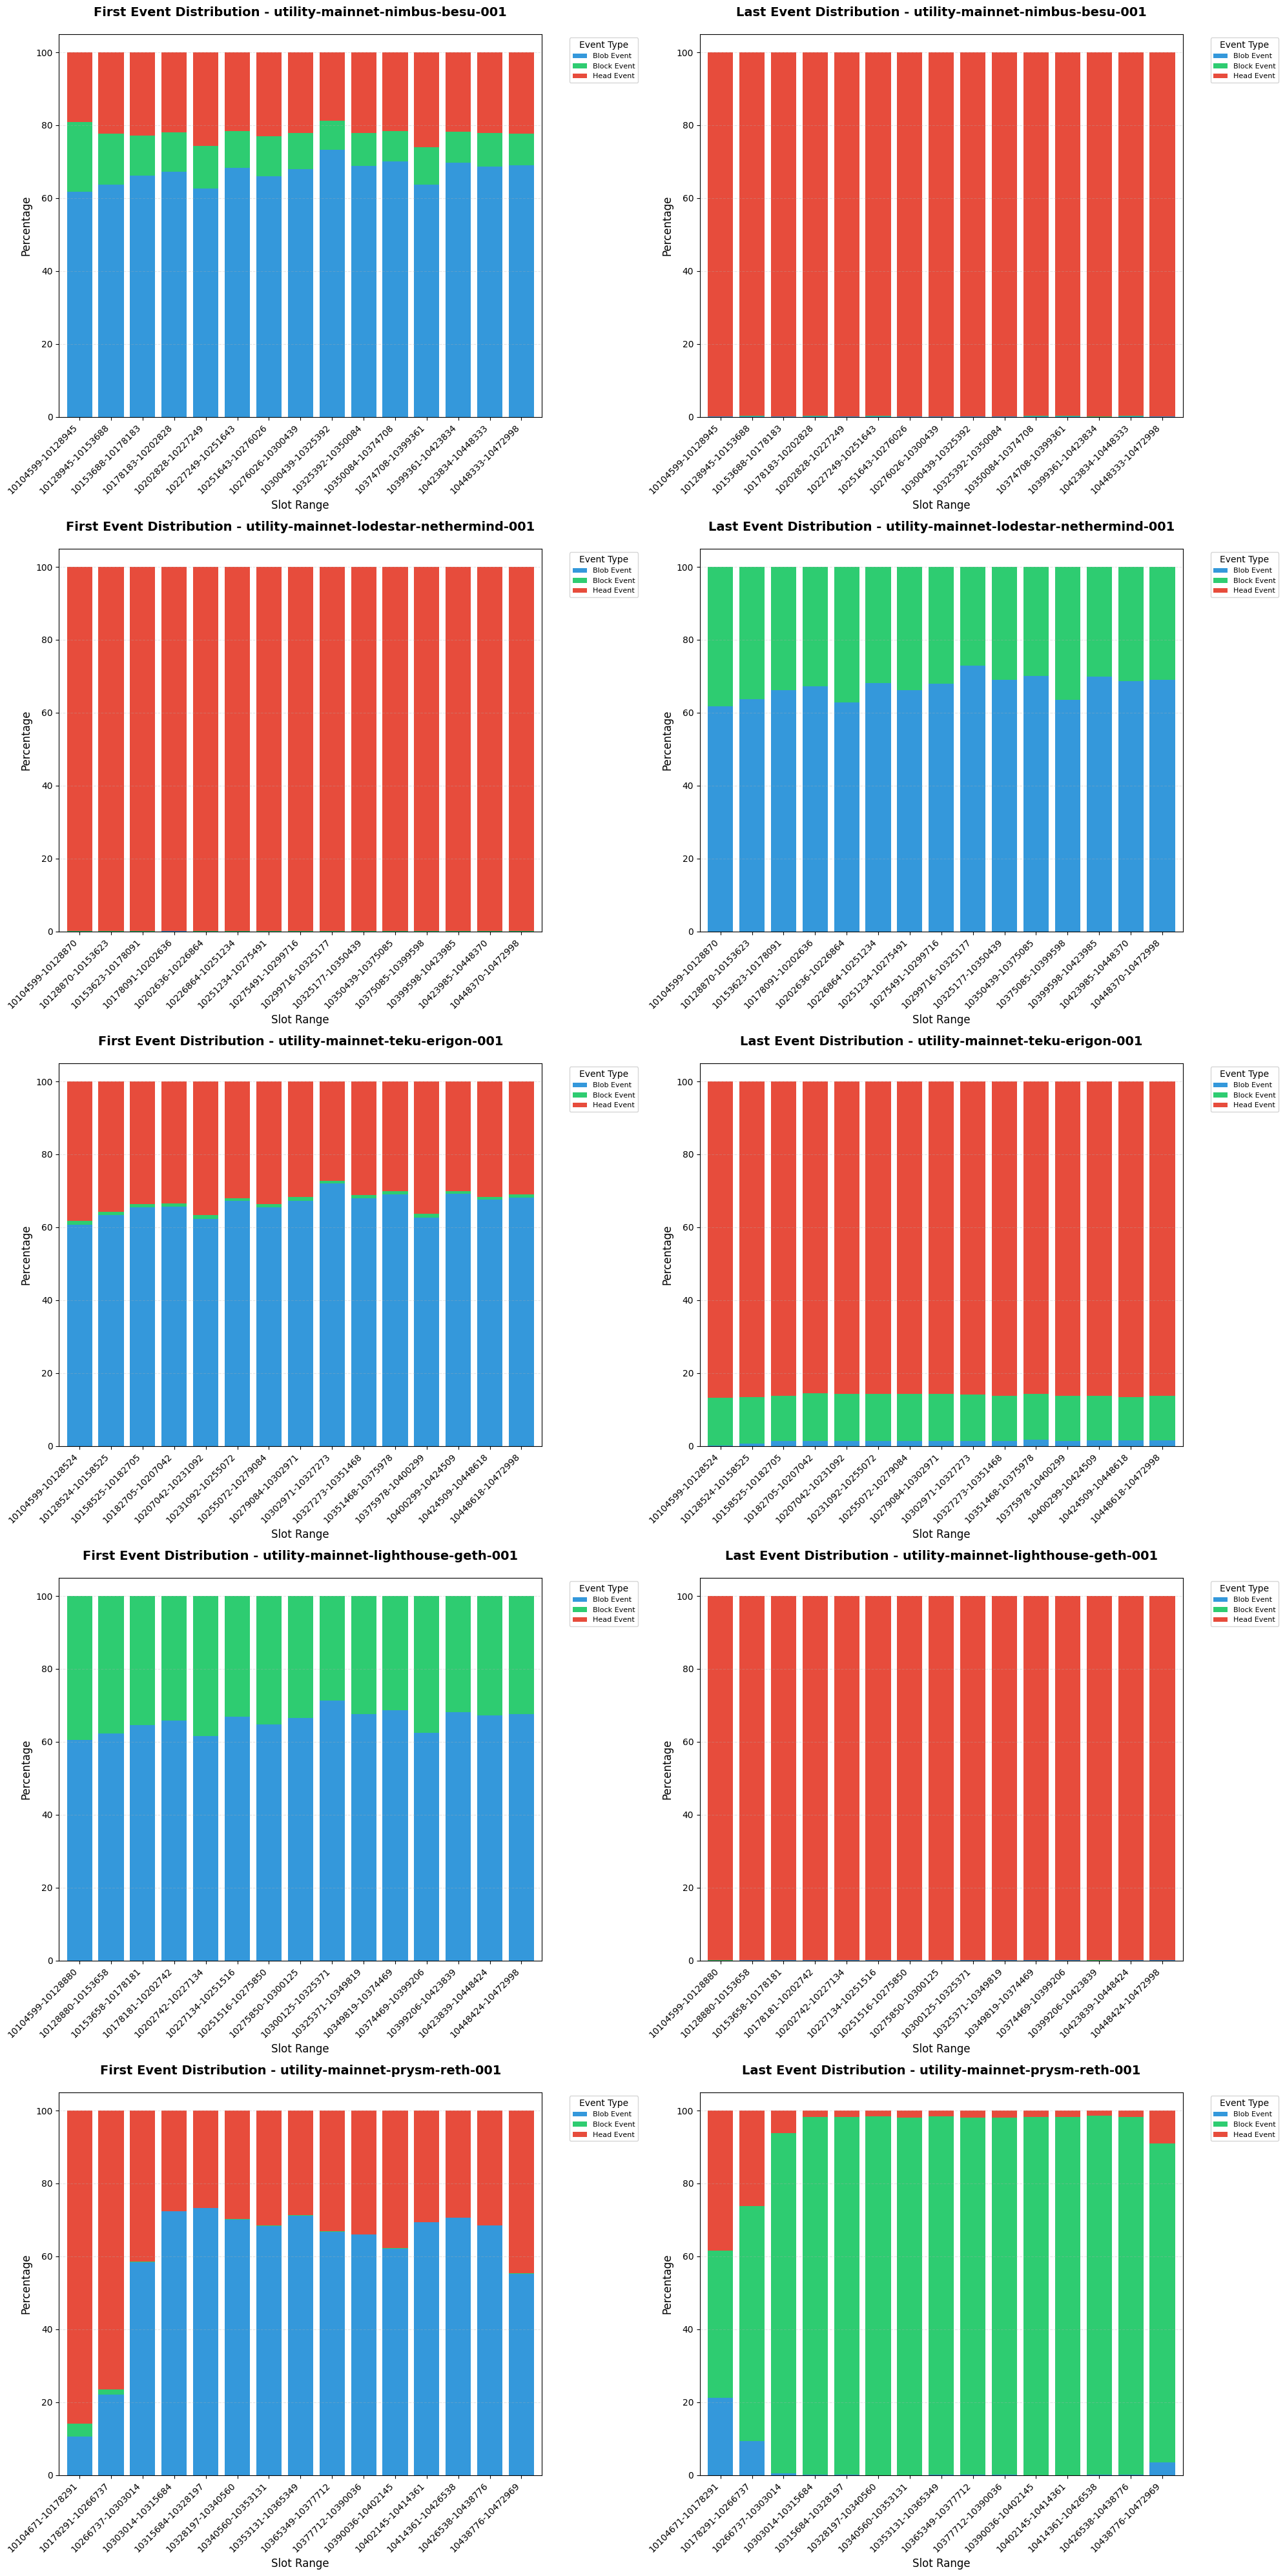

In [12]:
# Calculate which event happened first and last for each slot
interesting_arrival_times['first_event_type'] = interesting_arrival_times.apply(lambda row: 
    'Head Event' if row['head_arrival_time'] == row['first_event_time']
    else 'Block Event' if row['block_arrival_time'] == row['first_event_time'] 
    else 'Blob Event', axis=1)

interesting_arrival_times['last_event_time'] = interesting_arrival_times[['head_arrival_time', 'block_arrival_time', 'last_blob_arrival_time']].max(axis=1)
interesting_arrival_times['last_event_type'] = interesting_arrival_times.apply(lambda row:
    'Head Event' if row['head_arrival_time'] == row['last_event_time']
    else 'Block Event' if row['block_arrival_time'] == row['last_event_time']
    else 'Blob Event', axis=1)

# Create 15 slot buckets and get bucket ranges per client
clients = interesting_arrival_times['meta_client_name'].unique()
fig, axes = plt.subplots(len(clients), 2, figsize=(20, 8*len(clients)))

for i, client in enumerate(clients):
    client_data = interesting_arrival_times[interesting_arrival_times['meta_client_name'] == client]
    
    client_data['slot_bucket'], bins = pd.qcut(client_data['slot'], q=15, labels=False, retbins=True)
    bucket_ranges = [f'{int(bins[j])}-{int(bins[j+1])}' for j in range(len(bins)-1)]

    # First events plot
    first_bucket_counts = client_data.groupby(['slot_bucket', 'first_event_type']).size().unstack(fill_value=0)
    first_bucket_percentages = first_bucket_counts.div(first_bucket_counts.sum(axis=1), axis=0) * 100

    first_bucket_percentages.plot(
        kind='bar',
        stacked=True,
        color=['#3498db', '#2ecc71', '#e74c3c'],
        width=0.8,
        ax=axes[i,0]
    )
    axes[i,0].set_title(f'First Event Distribution - {client.split("/")[-1]}', pad=20, fontsize=14, fontweight='bold')
    axes[i,0].set_xlabel('Slot Range', fontsize=12)
    axes[i,0].set_ylabel('Percentage', fontsize=12)
    axes[i,0].legend(
        title='Event Type',
        title_fontsize=10,
        fontsize=8,
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )
    axes[i,0].grid(axis='y', linestyle='--', alpha=0.3)
    axes[i,0].set_xticklabels(bucket_ranges, rotation=45, ha='right')

    # Last events plot
    last_bucket_counts = client_data.groupby(['slot_bucket', 'last_event_type']).size().unstack(fill_value=0)
    last_bucket_percentages = last_bucket_counts.div(last_bucket_counts.sum(axis=1), axis=0) * 100

    last_bucket_percentages.plot(
        kind='bar',
        stacked=True,
        color=['#3498db', '#2ecc71', '#e74c3c'],
        width=0.8,
        ax=axes[i,1]
    )
    axes[i,1].set_title(f'Last Event Distribution - {client.split("/")[-1]}', pad=20, fontsize=14, fontweight='bold')
    axes[i,1].set_xlabel('Slot Range', fontsize=12)
    axes[i,1].set_ylabel('Percentage', fontsize=12)
    axes[i,1].legend(
        title='Event Type',
        title_fontsize=10,
        fontsize=8,
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )
    axes[i,1].grid(axis='y', linestyle='--', alpha=0.3)
    axes[i,1].set_xticklabels(bucket_ranges, rotation=45, ha='right')

    # Print statistics
    print(f"\nAverage Distribution for {client.split('/')[-1]} (First Events):")
    first_avg_pct = first_bucket_percentages.mean()
    for event_type, pct in first_avg_pct.items():
        print(f"{event_type}: {pct:.1f}%")

    print(f"\nAverage Distribution for {client.split('/')[-1]} (Last Events):")
    last_avg_pct = last_bucket_percentages.mean()
    for event_type, pct in last_avg_pct.items():
        print(f"{event_type}: {pct:.1f}%")

plt.tight_layout()
plt.show()
